# Introduction

See PyTorch's [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *
from fastai.column_data import *

In [3]:
from datetime import datetime
from torchvision import transforms
import torch.nn as nn
from utils import *
plt.rcParams['figure.figsize'] = [12, 4]
pd.set_option('display.max_rows', 11)

In [4]:
# import os
# import re
# import dill as pickle
# import itertools
# from datetime import datetime
# from tqdm import tqdm_notebook
# import numpy as np
# import pandas as pd
# from pandas import Series, DataFrame
# pd.set_option('display.max_rows', 40)
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# import matplotlib.transforms as mtransforms
# plt.rcParams['figure.figsize'] = [12, 4]

# from sklearn.metrics import confusion_matrix

# from utils import *

# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import torch.nn as nn
# import torch.optim as optim

# Simulated prices

**// TO DO:**

* Define a class that inherits `ModelData` from fastai's **dataset.py** with `trn_dl`, `trn_ds`, `val_dl`, `val_ds`, `test_dl`, `test_ds`. See fastai's **column_data.py** and **model.py**.
* Define a learner that inherits from class `Learner` (see **learner.py**).
* Add a `get_learner` method as in fastai's [column_data.py](https://github.com/fastai/fastai/blob/master/fastai/column_data.py) `CollabFilterDataset`.


* Simulated data ($L$ days) split between train data (days $0$ to $L_T$) and validation data (days $L_T - warmup$ to $L$).
* Test data: new simulation.
* Simulation of prices with different volatilities, drifts, return distributions and autocorrelation.


## Data Generation

In [5]:
def sim_path(N=500, sigma=0.35, S0=1, dt=1/250,
             mu=[0.05, 0.05], P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             wdt_hl=2):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S))
    res_df = res_df.assign(Date = pd.date_range(start=datetime(2018, 1, 1),
                                                periods=N, freq='D')).set_index('Date')
    
    res_df = res_df.assign(Open = res_df.Close.shift(-1).fillna(method='ffill') * \
                                    np.exp((np.random.rand(N) - 0.5) * sigma * np.sqrt(dt)))
    
    res_df = res_df.assign(High = res_df[['Open', 'Close']].max(axis=1) * \
                                np.exp(np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)),
                           Low = res_df[['Open', 'Close']].min(axis=1) * \
                                np.exp(- np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)))

    return res_df[['Open', 'High', 'Low', 'Close']]

In [6]:
price_df = add_changes(clean_trends(find_trends(sim_path())))
price_df

,Open,High,Low,Close,Smoothed,Trend,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End,Ch,Ch2,Ch3,Ch4
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.982355,1.024249,0.980291,1.000000,0.926917,-1.0,1.0,0.503078,0.067764,0.122066,0.019482,1.32887,1.067699,2.122335,2018-01-01,2018-04-08,0.000000,0.000000,0.000000e+00,0.000000e+00
2018-01-02,1.004558,1.021508,0.960395,0.982675,0.926488,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-08,-0.017477,0.000305,-5.338561e-06,9.330372e-08
2018-01-03,1.004738,1.033414,0.981537,1.005868,0.925776,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-08,0.023328,0.000544,1.269553e-05,2.961655e-07
2018-01-04,1.030274,1.036245,0.959536,1.000860,0.924783,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-08,-0.004992,0.000025,-1.243703e-07,6.208058e-10
2018-01-05,1.050844,1.057257,1.026701,1.033311,0.923511,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-08,0.031909,0.001018,3.248985e-05,1.036725e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-11,0.472714,0.491079,0.472018,0.481222,0.468491,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-23,2019-05-15,0.017292,0.000299,5.170349e-06,8.940460e-08
2019-05-12,0.473331,0.484680,0.457573,0.475013,0.468502,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-23,2019-05-15,-0.012986,0.000169,-2.190124e-06,2.844187e-08
2019-05-13,0.471018,0.477845,0.467055,0.476930,0.468511,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-23,2019-05-15,0.004028,0.000016,6.533343e-08,2.631362e-10


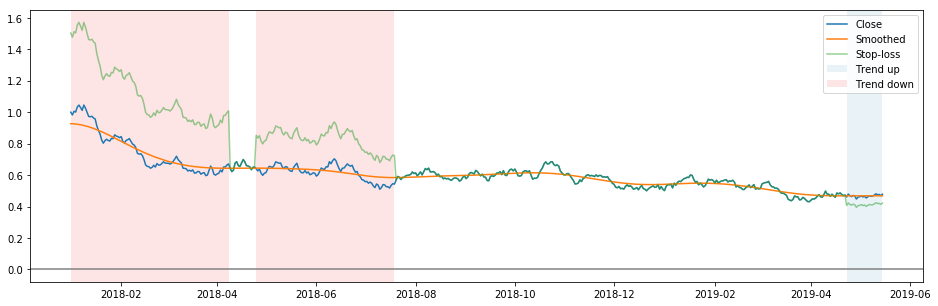

In [7]:
plot_trends(price_df)

## Dataset Class

In [8]:
def get_trend(df, sd, min_icagr=None,
              targets=['Trend', 'Max_Drawdown', 'ICAGR', 'Bliss'],
              is_multi=True):

    t_df = find_trends(df, sd)
    if min_icagr:
        t_df = clean_trends(t_df)

    t_df = t_df.loc[:, targets]
    if 'Trend' in targets and is_multi:
        t_df.Trend = t_df.Trend.add(1).astype(np.long)  # 0 = Down, 1 = No Trend, 2 = Up.
    t_df = t_df.rename({t: t + '_' + str(sd) for t in targets}, axis=1)
    
    return t_df

In [9]:
class SimulatedPricesDataset(Dataset):
    """Simulated Prices Dataset"""
    def __init__(self, N, sim_fun, 
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None,
                 Ch=None,
                 tech_windows=None,
                 is_multi=True,
                 transform=None):
        """
        Args:
            N (int): number of prices to simulate.
            sim_fun: function that returns a simulated price DataFrame: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.N = N
        self.sim_fun = sim_fun
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.Ch = Ch
        self.tech_windows = tech_windows
        self.transform = transform
        self.samples = []
        self.is_multi = is_multi
        self.is_reg = not is_multi
        
        for i in tqdm_notebook(range(N)):
            sim_df = self.sim_fun()
        
            targets_df = pd.concat(
                (get_trend(sim_df, s, min_icagr=self.min_icagr, targets=self.targets, is_multi=self.is_multi)
                 for s in self.sds),
                axis=1,
            )

            if self.tech_windows:
                sim_df = add_technical(add_changes(sim_df), windows=self.tech_windows)
            elif self.Ch:
                sim_df = add_changes(sim_df)

            if self.features:
                sim_df = sim_df[self.features]

            sample = {'features': sim_df, 'targets': targets_df}
            self.samples.append(sample)
        
        self.n_features = self.samples[0]['features'].shape[1]
        self.n_targets = self.samples[0]['targets'].shape[1]
        self.features_columns = self.samples[0]['features'].columns
        self.targets_columns = self.samples[0]['targets'].columns
    
    
    def __len__(self):
        return self.N
    
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [10]:
sim_dataset = SimulatedPricesDataset(10, lambda: sim_path(N=800),
                                     targets=['Trend'], sds = [20],
                                     min_icagr=0.3, tech_windows=[30, 100])

In [11]:
sim_dataset.n_features, sim_dataset.n_targets

(20, 1)

In [12]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)

(800, 20) (800, 1)


In [13]:
sim_j['features'].columns

Index(['Open', 'High', 'Low', 'Close', 'Ch', 'Ch2', 'Ch3', 'Ch4', 'SMA_30',
       'SMA_100', 'sigma2_SMA_30', 'sigma2_SMA_100', 'skew_SMA_30',
       'skew_SMA_100', 'kurt_SMA_30', 'kurt_SMA_100', 'Support_30',
       'Support_100', 'Resistance_30', 'Resistance_100'],
      dtype='object')

In [14]:
sim_j['features'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Open,0.998189,0.981091,0.996034,0.962484,0.931387
High,1.013140,1.039497,1.002879,1.028962,0.992049
Low,0.980531,0.950755,0.957201,0.941264,0.920885
Close,1.000000,0.999365,0.980015,0.987577,0.968907
Ch,0.000000,-0.000635,-0.019552,0.007687,-0.019086
...,...,...,...,...,...
kurt_SMA_100,-1.000000,-1.000000,-0.006318,0.066828,-0.827278
Support_30,0.980531,0.950755,0.950755,0.941264,0.920885
Support_100,0.980531,0.950755,0.950755,0.941264,0.920885
Resistance_30,1.013140,1.039497,1.039497,1.039497,1.039497


In [15]:
sim_j['targets'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Trend_20,0,0,0,0,0


## Transforms

In [16]:
class ToArray(object):
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        return {'features': features.values, 'targets': targets.values}
        

class RandomCrop(object):
    """Crops randomly an inner segment of the time series.
    
    Args:
        output_size (int): length of the desired time series.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        
        size = len(features)
        if self.output_size < size:
            start = np.random.randint(0, size - self.output_size)
            features = features[start: start + self.output_size, :]
            targets = targets[start: start + self.output_size, :]
        
        return {'features': features, 'targets': targets}


class StartAt(object):
    def __init__(self, at):
        assert at > 0
        self.at = at
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        # Open starts at self.at
        features[:, :4] = self.at * features[:, :4] / features[0, 0]
        
        return {'features': features, 'targets': targets}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']

        return {'features': torch.from_numpy(features), 
                'targets': torch.from_numpy(targets)}

In [17]:
# sim_dataset = SimulatedPricesDataset(...,
#                                      transform=transforms.Compose([
#                                          ToArray(), RandomCrop(480)
#                                      ])
#                                     )

sim_dataset.transform = transforms.Compose([ToArray(), RandomCrop(480)])

(480, 20) (480, 1)


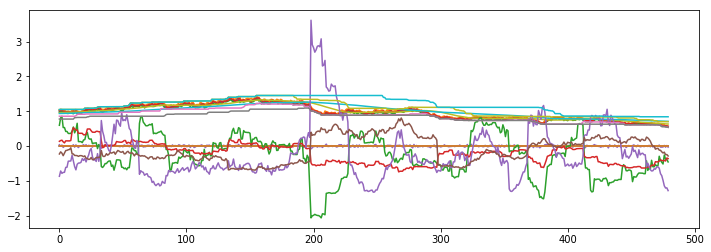

In [18]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)
plt.plot(sim_j['features']);

In [19]:
composed = transforms.Compose([ToArray(), RandomCrop(480), StartAt(100), ToTensor()])

sim_dataset.transform = composed

In [20]:
sim_j = sim_dataset[2]
print(sim_j['features'].size(), sim_j['targets'].size())

torch.Size([480, 20]) torch.Size([480, 1])


In [21]:
sim_j['features'][:6, :4]


 100.0000  103.2262   98.2660  100.1122
 102.6785  104.5326   96.5346   99.6914
 103.5553  106.4963  100.8265  102.7019
 103.8072  108.2664  101.0553  103.3272
 100.4659  106.5554  100.1178  103.7266
 100.6578  102.3248   98.6829  101.4090
[torch.DoubleTensor of size 6x4]

In [22]:
sim_j['targets'][:6, :]


 2
 2
 2
 2
 2
 2
[torch.IntTensor of size 6x1]

## Iterating through the dataset

In [23]:
sds = [20]
tech_win = [10]
min_icagr = 0.3

train_dataset = SimulatedPricesDataset(100, lambda: sim_path(N=500),
                                       targets=['Trend'],
                                       sds=sds, min_icagr=min_icagr,
                                       tech_windows=tech_win,
                                       transform=transforms.Compose([
                                           ToArray(),
                                           RandomCrop(480),
                                           ToTensor()
                                       ]))

test_dataset = SimulatedPricesDataset(50, lambda: sim_path(N=300),
                                      targets=['Trend'],
                                      sds=sds, min_icagr=min_icagr,
                                      tech_windows=tech_win,
                                      transform=transforms.Compose([
                                          ToArray(),
                                          ToTensor()
                                      ]))

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print('Train:')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

print('Test:')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

Train:
0 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
1 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
Test:
0 torch.Size([50, 300, 14]) torch.Size([50, 300, 1])


In [25]:
input = next(iter(train_loader))['features']
input


( 0 ,.,.) = 
  1.0230  1.0576  1.0071  ...  -0.8081  0.9747  1.0987
  1.0059  1.0457  0.9829  ...  -0.8142  0.9805  1.0987
  1.0218  1.0655  0.9620  ...  -0.9533  0.9620  1.0987
           ...             ⋱             ...          
  1.4338  1.5426  1.4166  ...  -1.0415  1.3962  1.6566
  1.4718  1.4902  1.4242  ...  -1.1343  1.3962  1.6555
  1.4419  1.5103  1.4378  ...  -1.0664  1.3962  1.6555

( 1 ,.,.) = 
  0.9655  0.9703  0.9578  ...   0.7909  0.9229  1.0570
  0.9823  0.9857  0.9530  ...   0.5598  0.9229  1.0570
  0.9632  1.0060  0.9385  ...   1.0003  0.9229  1.0570
           ...             ⋱             ...          
  0.5802  0.5813  0.5521  ...  -1.0994  0.5510  0.6171
  0.5900  0.5906  0.5711  ...  -0.9537  0.5510  0.6171
  0.5760  0.6020  0.5555  ...  -1.1788  0.5510  0.6171

( 2 ,.,.) = 
  0.9925  1.0285  0.9621  ...  -1.0000  0.9621  1.0285
  0.9841  1.0435  0.9738  ...  -1.4792  0.9621  1.0435
  0.9436  0.9901  0.9213  ...  -1.5293  0.9213  1.0435
           ...         

In [26]:
next(iter(input.chunk(input.size(1), dim=1))).shape

torch.Size([50, 1, 14])

In [27]:
next(iter(input.chunk(input.size(1), dim=1))).contiguous().view(-1, 14).size()

torch.Size([50, 14])

## ModelData

In [28]:
class PriceModelData(ModelData):
    
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True, call=None):
        
        self.call = call
        
        if test_ds is not None:
                test_dl = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)
        super().__init__(path, 
                         torch.utils.data.DataLoader(trn_ds, bs, shuffle=shuffle),
                         torch.utils.data.DataLoader(val_ds, bs, shuffle=False),
                         test_dl)
    
    @classmethod
    def simulate(cls, N, bs, sim_fun=sim_path, n_days=500,
                 targets=['Trend'],
                 sds=[10, 20, 30], min_icagr=0.5,
                 Ch=True,
                 tech_windows=[10, 20, 30],
                 features=None,
                 ):
        
        
        call = dict(N=N, n_days=n_days, sim_fun=sim_fun,
                    targets=targets, features=features,
                    sds=sds, min_icagr=min_icagr,
                    Ch=Ch, tech_windows=tech_windows)
        
        trn_N, val_N, test_N = N
        trn_ds = SimulatedPricesDataset(trn_N, lambda: sim_path(N=n_days + 30),
                                        targets=['Trend'],
                                        sds=sds, min_icagr=min_icagr,
                                        tech_windows=tech_windows,
                                        transform=transforms.Compose([
                                            ToArray(),
                                            RandomCrop(n_days - 30),
                                            ToTensor()
                                        ]))
        val_ds = SimulatedPricesDataset(val_N, lambda: sim_path(N=n_days),
                                        targets=['Trend'],
                                        sds=sds, min_icagr=min_icagr,
                                        tech_windows=tech_windows,
                                        transform=transforms.Compose([
                                            ToArray(),
                                            ToTensor()
                                        ]))
        test_ds = SimulatedPricesDataset(test_N, lambda: sim_path(N=n_days),
                                         targets=['Trend'],
                                         sds=sds, min_icagr=min_icagr,
                                         tech_windows=tech_windows,
                                         transform=transforms.Compose([
                                             ToArray(),
                                             ToTensor()
                                         ]))
        
        return cls('input/Sim/', trn_ds, val_ds, bs, test_ds, True, call)
        
        

In [29]:
sim_data = PriceModelData.simulate((20, 10, 10), bs=10, sds=[20])

In [30]:
input = next(iter(sim_data.trn_dl))['features']
input


( 0 ,.,.) = 
  1.0719e+00  1.1135e+00  1.0688e+00  ...   1.1820e+00  1.1820e+00  1.1820e+00
  1.0838e+00  1.1089e+00  1.0271e+00  ...   1.1820e+00  1.1820e+00  1.1820e+00
  1.0717e+00  1.0916e+00  1.0278e+00  ...   1.1820e+00  1.1820e+00  1.1820e+00
                 ...                   ⋱                   ...                
  1.6328e+00  1.6336e+00  1.5646e+00  ...   1.6928e+00  1.6928e+00  1.6928e+00
  1.6378e+00  1.6543e+00  1.6283e+00  ...   1.6928e+00  1.6928e+00  1.6928e+00
  1.6389e+00  1.6614e+00  1.5922e+00  ...   1.6928e+00  1.6928e+00  1.6928e+00

( 1 ,.,.) = 
  1.1137e+00  1.1355e+00  1.0710e+00  ...   1.1355e+00  1.1355e+00  1.1355e+00
  1.1237e+00  1.1653e+00  1.0883e+00  ...   1.1653e+00  1.1653e+00  1.1653e+00
  1.1077e+00  1.1364e+00  1.0926e+00  ...   1.1653e+00  1.1653e+00  1.1653e+00
                 ...                   ⋱                   ...                
  5.3874e-01  5.5266e-01  5.0878e-01  ...   5.5266e-01  5.5266e-01  5.5266e-01
  5.3596e-01  5.4561e-01

## LSTM Model

**// TO DO:**

* See fastai's [column_data.py](https://github.com/fastai/fastai/blob/master/fastai/column_data.py) `MixedInputModel` for list comprehension of layers. `self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])`.
* Multiple dimension softmax and `NLLLoss`, for Trend_5, Trend_10, etc.
* Weights in loss function: prob(no trend) really low.

In [31]:
input_t = next(iter(input.chunk(input.size(1), dim=1)))
input_t.size()

torch.Size([10, 1, 26])

In [32]:
input_t.contiguous().view(-1, 26)



Columns 0 to 5 
 1.0719e+00  1.1135e+00  1.0688e+00  1.0941e+00 -1.3276e-02  1.7625e-04
 1.1137e+00  1.1355e+00  1.0710e+00  1.1049e+00  1.2337e-02  1.5219e-04
 9.4366e-01  9.8203e-01  9.2152e-01  9.5240e-01 -3.2378e-02  1.0484e-03
 1.0659e+00  1.1018e+00  1.0592e+00  1.0799e+00  1.9417e-02  3.7701e-04
 8.0671e-01  8.2797e-01  7.8122e-01  8.0865e-01 -2.8151e-02  7.9250e-04
 9.4986e-01  1.0218e+00  9.1366e-01  9.8949e-01 -3.1705e-02  1.0052e-03
 8.5937e-01  9.1820e-01  8.2920e-01  8.8446e-01  3.7101e-03  1.3765e-05
 9.8728e-01  9.8908e-01  9.3545e-01  9.6797e-01  1.6135e-02  2.6034e-04
 9.1368e-01  9.4033e-01  8.8833e-01  9.3802e-01 -8.2024e-03  6.7280e-05
 9.3488e-01  9.8102e-01  9.0660e-01  9.4879e-01 -2.7421e-02  7.5189e-04

Columns 6 to 11 
-2.3399e-06  3.1064e-08  1.0712e+00  1.0647e+00  1.0647e+00  6.8035e-04
 1.8775e-06  2.3162e-08  1.0485e+00  1.0485e+00  1.0485e+00  5.1815e-04
-3.3944e-05  1.0990e-06  9.9320e-01  9.7500e-01  9.6693e-01  2.5821e-04
 7.3203e-06  1.4214e-07  1.0

In [33]:
aux = nn.LSTMCell(26, 20)
aux.cpu()

LSTMCell(26, 20)

In [34]:
aux(V(input_t.contiguous().view(-1, 26).float()).cpu(),
    (V(torch.zeros(10, 20).float()).cpu(), V(torch.zeros(10, 20).float()).cpu()))

C:\Users\REUTERS\AppData\Local\conda\conda\envs\fastai-cpu\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


(Variable containing:
 
 Columns 0 to 9 
 -0.0713  0.1365 -0.0898  0.0288  0.2213  0.3306 -0.0945  0.1365 -0.0179 -0.0636
 -0.0934  0.0960 -0.2992 -0.1101  0.0833  0.2660 -0.2240  0.0475 -0.2518 -0.1587
 -0.3007  0.1001 -0.1253 -0.0496  0.0567  0.1531 -0.1798  0.0519  0.0147  0.0702
 -0.0778  0.1287 -0.0949  0.0294  0.2051  0.3141 -0.1021  0.1210 -0.0147 -0.0605
 -0.0898  0.1161 -0.0483  0.0158  0.1730  0.2399 -0.0806  0.0849  0.0723 -0.0078
 -0.0441  0.0813 -0.0100  0.0476  0.1631  0.2505 -0.0754  0.0446  0.0639 -0.0174
 -0.1883  0.1328 -0.0795 -0.0546  0.1336  0.1918 -0.1634  0.0446  0.0642  0.0312
 -0.1445  0.1457 -0.0850 -0.0486  0.1550  0.2350 -0.1460  0.0721  0.0178 -0.0256
 -0.0812  0.1081 -0.0687 -0.0211  0.1013  0.1512 -0.1901 -0.0164  0.0437  0.0266
 -0.0939  0.0824  0.0191  0.0215  0.1249  0.2020 -0.0880  0.0211  0.0991  0.0220
 
 Columns 10 to 19 
  0.1315  0.1983  0.0132  0.0705 -0.0309 -0.0338 -0.0534  0.1521 -0.0520  0.1722
  0.0438  0.1485 -0.0932  0.1235 -0.0564  0.017

In [35]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=3, warmup=60, nll_weights=None):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1).float()
        self.lstm2 = nn.LSTMCell(h1, h2).float()
        self.linear = nn.Linear(h2, hL).float()
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.warmup = 60
        self.loss_fun = nn.NLLLoss(weight=nll_weights)
        
    
    def init_hidden(self):
        self.h_t = V(torch.zeros(input.size(0), self.h1).float()).cpu()
        self.c_t = V(torch.zeros(input.size(0), self.h1).float()).cpu()
        self.h_t2 = V(torch.zeros(input.size(0), self.h2).float()).cpu()
        self.c_t2 = V(torch.zeros(input.size(0), self.h2).float()).cpu()

    
    def forward(self, input):
        self.init_hidden()
        outputs = []
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            self.h_t, self.c_t = self.lstm1(V(input_t.contiguous().view(-1, self.h0).float()).cpu(), (self.h_t, self.c_t))
            self.h_t2, self.c_t2 = self.lstm2(self.h_t, (self.h_t2, self.c_t2))
            output = self.linear(self.h_t2)
            output = self.softmax(output)
            outputs += [output]

        outputs = torch.stack(outputs, 1)
        return outputs
    

    def loss(self, y_hat, y_true):
        loss = 0
        for i in range(self.warmup, y_hat.size()[1]):
            loss = loss + self.loss_fun(V(y_hat).cpu()[:, i, :], V(y_true).cpu()[:, i, :].squeeze(dim=1))
        return loss / (y_hat.size()[1] - self.warmup)

In [36]:
Series(np.concatenate([sim_j['targets'].numpy().flatten() for sim_j in sim_dataset])).value_counts()

2    2316
0    1967
1     517
dtype: int64

In [37]:
_, freqs = np.unique([sim_j['targets'].numpy().flatten() for sim_j in train_dataset], return_counts=True)
weights = torch.Tensor(freqs / sum(freqs))

In [38]:
# build the model
#seq = Sequence(h0=train_loader.dataset.n_features, nll_weights=weights)
seq = Sequence(h0=sim_data.trn_dl.dataset.n_features, nll_weights=weights)
seq.float()

Sequence(
  (lstm1): LSTMCell(26, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss(
  )
)

In [39]:
sample = next(iter(sim_data.trn_dl))  # next(iter(train_loader))
inputs = sample['features']
targets = sample['targets']

In [40]:
out = seq(inputs)

In [41]:
out.size(), targets.size()

(torch.Size([10, 470, 3]), torch.Size([10, 470, 1]))

In [42]:
loss = seq.loss(out, V(targets.long()).cpu())

In [43]:
loss.backward()

In [44]:
adam = torch.optim.Adam(seq.parameters(), lr=1e-2)
fit(seq, sim_data, 2, adam, seq.loss)

  0%|                                                                                                                  | 0/2 [00:00<?, ?it/s]


NotImplementedError: <U8

In [ ]:
test_sample = next(iter(sim_data.test_dl))  # next(iter(test_loader))
test_inputs = test_sample['features']
test_targets = test_sample['targets']

In [ ]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

In [ ]:
seq.loss(test_out, test_targets)

In [45]:
fit(seq, sim_data, 2, optim.SGD(seq.parameters(), 1e-3, momentum=0.9), seq.loss)

  0%|                                                                                                                  | 0/2 [00:00<?, ?it/s]


NotImplementedError: <U8

### Learner

In [ ]:
model_summary(seq, 1)

In [ ]:
class PriceModelLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return seq.loss

    def summary(self): return model_summary(self.model, [torch.ones(3).long(), torch.ones(3).long()])


In [ ]:
sim_learner = PriceModelLearner(sim_data, BasicModel(seq, name='seq'))
sim_learner

In [ ]:
sim_learner.fit(1e-3, 2)

### Train

#### Find lr

In [ ]:
losses = []
lrs = np.exp(np.arange(np.log(1e-6), np.log(1), step=0.1))
sched_lrs = []
optimizer = optim.Adam(seq.parameters(), lr=1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lrs[epoch])


for e in tqdm_notebook(np.arange(len(lrs) // (len(train_dataset) / train_loader.batch_size) + 1),
                       desc='Epoch:'):

    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
        scheduler.step()
        sched_lrs.append(scheduler.get_lr())
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        
        if scheduler.last_epoch == len(lrs) - 1: break
    if scheduler.last_epoch == len(lrs) - 1: break


In [ ]:
plt.semilogx(np.array(sched_lrs).flatten()[:250], losses[:250])
plt.xlabel('Learning rate (log-scale)')
plt.ylabel('Loss')
plt.show()

#### Train the model

In [ ]:
losses = []
test_losses = []
seq = Sequence(h0=train_dataset.n_features, nll_weights=weights)
seq.double()

In [ ]:
optimizer = optim.Adam(seq.parameters(), lr=1e-4)
# optimizer = optim.SGD(seq.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
epochs = 10
for e in tqdm_notebook(range(epochs), desc='Epoch:'):
    
    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
    
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    
    if e % 1 == 0:
        with torch.no_grad():
            test_sample = next(iter(test_loader))
            test_inputs, test_targets = test_sample['features'], test_sample['targets']
            test_out = seq(test_inputs)
            test_loss = seq.loss(test_out, test_targets)
            test_losses.append(test_loss.item())
        print('Epoch: ', e,
              ', training loss: ', np.mean(losses[-(len(train_dataset) // train_loader.batch_size):]),
              ', test loss: ', test_loss.item(), sep='')


In [ ]:
plt.plot(losses)

In [ ]:
test_sample = next(iter(test_loader))
test_inputs, test_targets = test_sample['features'], test_sample['targets']
test_out = seq(test_inputs)

In [ ]:
j = np.random.randint(len(test_dataset))
features_j = test_inputs[j, ...]
x_j = pd.DataFrame(features_j.numpy(), columns=test_dataset.features_columns)

In [ ]:
targets_j = test_targets[j, ...]
y_j = pd.DataFrame(targets_j.numpy(), columns=test_dataset.targets_columns)

In [ ]:
out_j = test_out[j, ...]
yh_j = pd.DataFrame(np.exp(out_j.detach().numpy()), columns=['Down', 'No_Trend', 'Up'])
yh_j = yh_j.assign(y_hat = pd.DataFrame(np.exp(out_j.detach().numpy())).idxmax(axis=1))

In [ ]:
confusion_matrix(y_j.values, yh_j.y_hat)/len(y_j)

In [ ]:
res_j = pd.concat((x_j, y_j, yh_j), axis=1)
res_j[['Close', 'No_Trend', 'Up', 'Down']].plot()

In [ ]:
res_j[['Close', 'Trend_20', 'y_hat']].plot()

# Sharadar prices //

> // How to manage train and validation samples?

In [ ]:
class SharadarPricesDataset(Dataset):
    """Sharadar Prices Dataset"""
    def __init__(self, root_dir, min_length,
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None, 
                 transform=None):
        """
        Args:
            root_dir (str): directory with data frames: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.min_length = min_length
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.transform = transform
        
        # Only series longer than min_length
        tickers = os.listdir(root_dir)
        lengths = [len(pd.read_feather(os.path.join(root_dir, f)))
                   for f in tickers]
        tickers_df = DataFrame(data={'ticker': tickers, 'length': lengths})
        self.fnames = list(
            tickers_df.query('length > ' + str(self.min_length)).ticker.values
        )
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        
        f_name = os.path.join(self.root_dir,
                              self.fnames[idx])
        
        df = pd.read_feather(f_name).set_index('Date')
        
        targets_df = pd.concat(
            (get_trend(df, s, min_icagr=self.min_icagr, targets=self.targets)
             for s in self.sds),
            axis=1,
        )
        
        if self.features:
            df = df[self.features]
        
        sample = {'features': df, 'targets': targets_df}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
sh_train = 'input/Quandl/Sharadar/train/'

sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3)
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].shape, sh_j['targets'].shape)

In [ ]:
sh_j['features'].head().T

In [ ]:
sh_j['targets'].head().T

## Transforms

In [ ]:
# sh_train = 'input/Quandl/Sharadar/train/'
# sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3,
#                                    transform=transforms.Compose([
#                                        ToArray(),
#                                        RandomCrop(500),
#                                        StartAt(1),
#                                        ToTensor(),
#                                      ])
#                                    )

In [ ]:
composed = transforms.Compose([
    ToArray(),
    RandomCrop(300),
    StartAt(1),
    ToTensor()
])

sh_dataset.transform = composed
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].size(), sh_j['targets'].size())

In [ ]:
plt.plot(sh_j['features'][:, :4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 5:].numpy());

## DataLoader

In [ ]:
sh_loader = DataLoader(sh_dataset, batch_size=6)

for i_batch, sample_batched in enumerate(sh_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

# End

In [ ]:
df = pd.read_feather('input/Quandl/Sharadar/train/NIOBF.feather').set_index('Date')
df = find_trends(df)

In [ ]:
df

In [ ]:
(df.Trend_End - df.Trend_Start).min()

In [ ]:
plot_trends(df)

In [ ]:
df.Ratio.dropna().sort_values()

# TO DO:

* Check why the ratio is < 0.
* `SharadarPricesDataset` that computes data and saves it to disk on `__init__`, and only loads df on `__get_item__`.